In [8]:
import concurrent.futures
import time
import sys
from dimod import DiscreteQuadraticModel
from dwave.system import LeapHybridDQMSampler
import pandas as pd
import numpy as np
import seaborn as sns
from distance_matrix_creator import *
import matplotlib.pyplot as plt
import dwave.inspector

In [9]:
Nfacil = 14
factory_rows = 9
factory_collumns = 9
Npos = factory_rows*factory_collumns
positions = []
facilities = [i for i in range(Nfacil)]
positions = [i for i in range(Npos)]
np.set_printoptions(linewidth=1000, suppress=True,threshold= sys.maxsize)
flow = pd.read_csv("csv_files/flowmatrixdqm.csv", header = None)
flow = (flow.to_numpy())**3
flow = np.round(flow)
flow = np.triu(flow)
flow = np.array(flow)
for i in range(1,len(flow[0])):
    flow[0][i] = 3
print(flow,"\n\n")


distance = rectdistancematrix(factory_rows,factory_collumns)
# distance = np.round(distance,decimals=3)
distance = np.triu(np.array(distance))
distance = (np.array(distance))#**3)/5
distance = np.round(distance,decimals=3)
print(distance)
print(np.shape(distance))

print("Facilities = ", facilities)
print("Positions = ",positions)

facility_size_noempty = [10,4,7,4,2,1,14,2,14,3,1,3,2]
emptyspace = [Npos - np.sum(facility_size_noempty)]
facility_size = emptyspace + facility_size_noempty
facility_size[0] = 0
print(facility_size)

[[   1    3    3    3    3    3    3    3    3    3    3    3    3    3]
 [   0 2197  216    8    8    8    8    8    8    8    8    8    8    8]
 [   0    0 2197  216  216  216   27   27   64    8   64   64   27   64]
 [   0    0    0 2197   64  125   27    8    8    8    8    8  -64    8]
 [   0    0    0    0 2197   27  125    8   64    8    8    8  -64    8]
 [   0    0    0    0    0 2197   64  125   27    8    8    8  -64    8]
 [   0    0    0    0    0    0 2197   27  125    8   27    8  -64    8]
 [   0    0    0    0    0    0    0 2197   64  125   27    8    8    8]
 [   0    0    0    0    0    0    0    0 2197  125   27   27    8    8]
 [   0    0    0    0    0    0    0    0    0 2197  125  125   27   27]
 [   0    0    0    0    0    0    0    0    0    0 2197   64   27   64]
 [   0    0    0    0    0    0    0    0    0    0    0 2197   27   64]
 [   0    0    0    0    0    0    0    0    0    0    0    0 2197   27]
 [   0    0    0    0    0    0    0    0    0    0

#Building a Variable for each Position

In [10]:
labels = []
for p in positions:
    labels.append(f'P{p}')
print(np.array(labels))

['P0' 'P1' 'P2' 'P3' 'P4' 'P5' 'P6' 'P7' 'P8' 'P9' 'P10' 'P11' 'P12' 'P13' 'P14' 'P15' 'P16' 'P17' 'P18' 'P19' 'P20' 'P21' 'P22' 'P23' 'P24' 'P25' 'P26' 'P27' 'P28' 'P29' 'P30' 'P31' 'P32' 'P33' 'P34' 'P35' 'P36' 'P37' 'P38' 'P39' 'P40' 'P41' 'P42' 'P43' 'P44' 'P45' 'P46' 'P47' 'P48' 'P49' 'P50' 'P51' 'P52' 'P53' 'P54' 'P55' 'P56' 'P57' 'P58' 'P59' 'P60' 'P61' 'P62' 'P63' 'P64' 'P65' 'P66' 'P67' 'P68' 'P69' 'P70' 'P71' 'P72' 'P73' 'P74' 'P75' 'P76' 'P77' 'P78' 'P79' 'P80']


#Initialise BQM

In [11]:
dqm = DiscreteQuadraticModel()
for p in positions:
    dqm.add_variable(Nfacil, label=labels[p])
# print(dqm)
print(dqm.variables)

Variables(['P0', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29', 'P30', 'P31', 'P32', 'P33', 'P34', 'P35', 'P36', 'P37', 'P38', 'P39', 'P40', 'P41', 'P42', 'P43', 'P44', 'P45', 'P46', 'P47', 'P48', 'P49', 'P50', 'P51', 'P52', 'P53', 'P54', 'P55', 'P56', 'P57', 'P58', 'P59', 'P60', 'P61', 'P62', 'P63', 'P64', 'P65', 'P66', 'P67', 'P68', 'P69', 'P70', 'P71', 'P72', 'P73', 'P74', 'P75', 'P76', 'P77', 'P78', 'P79', 'P80'])


#Objective function

In [12]:
for j in range(len(positions)):
    for jj in range(j+1,len(positions)):
        for i in range(Nfacil):
            for ii in range(Nfacil):
                if i == 0 or ii == 0:
                    dqm.set_quadratic_case(labels[j],i,labels[jj],ii,distance[j][jj]*flow[i][ii])
                else:    
                    dqm.set_quadratic_case(labels[j],i,labels[jj],ii,distance[j][jj]*flow[i][ii]/(i*ii))

#constraint 1: only 1 machine is placed per position

In [13]:
for f in range(Nfacil):
    if f == 0:
        c1 = [(labels[p],f,1) for p in positions]
        dqm.add_linear_equality_constraint(
            c1,
            constant=0,
            lagrange_multiplier=1
        )
    else:
        c1 = [(labels[p],f,1/f) for p in positions]
        dqm.add_linear_equality_constraint(
            c1,
            constant=-1*facility_size[f],
            lagrange_multiplier=1
        ) 
    
    print(c1)

[('P0', 0, 1), ('P1', 0, 1), ('P2', 0, 1), ('P3', 0, 1), ('P4', 0, 1), ('P5', 0, 1), ('P6', 0, 1), ('P7', 0, 1), ('P8', 0, 1), ('P9', 0, 1), ('P10', 0, 1), ('P11', 0, 1), ('P12', 0, 1), ('P13', 0, 1), ('P14', 0, 1), ('P15', 0, 1), ('P16', 0, 1), ('P17', 0, 1), ('P18', 0, 1), ('P19', 0, 1), ('P20', 0, 1), ('P21', 0, 1), ('P22', 0, 1), ('P23', 0, 1), ('P24', 0, 1), ('P25', 0, 1), ('P26', 0, 1), ('P27', 0, 1), ('P28', 0, 1), ('P29', 0, 1), ('P30', 0, 1), ('P31', 0, 1), ('P32', 0, 1), ('P33', 0, 1), ('P34', 0, 1), ('P35', 0, 1), ('P36', 0, 1), ('P37', 0, 1), ('P38', 0, 1), ('P39', 0, 1), ('P40', 0, 1), ('P41', 0, 1), ('P42', 0, 1), ('P43', 0, 1), ('P44', 0, 1), ('P45', 0, 1), ('P46', 0, 1), ('P47', 0, 1), ('P48', 0, 1), ('P49', 0, 1), ('P50', 0, 1), ('P51', 0, 1), ('P52', 0, 1), ('P53', 0, 1), ('P54', 0, 1), ('P55', 0, 1), ('P56', 0, 1), ('P57', 0, 1), ('P58', 0, 1), ('P59', 0, 1), ('P60', 0, 1), ('P61', 0, 1), ('P62', 0, 1), ('P63', 0, 1), ('P64', 0, 1), ('P65', 0, 1), ('P66', 0, 1), ('P6

Removing 0 bias variables and couplers from BQM

In [14]:
# new_dqm = DiscreteQuadraticModel(dqm.linear, {interaction: bias for interaction, bias in dqm.quadratic.items() if bias}, dqm.offset, dqm.vartype)
file = open("txt_files/dqm.txt", "w")
file.close()
print(dqm)

#running the solver

In [15]:
sampler = LeapHybridDQMSampler()
# numreads = 200 #number of samples for simulated annealer
timelimit = 20 #time limit for hybrid sampler
sampleset = sampler.sample_dqm(dqm,time_limit=timelimit)

Printing Output Solutions

   P0 P1 P2 P3 P4 P5 P6 P7 P8 P9 P10 P11 P12 P13 ... P80      energy num_oc.
23 11 11 13 13 13  8  8  6  6 11  11  13  13  13 ...   0 6369.543015       1
11 11 11 13 13 13  8  8  6  6 11  11  13  13  13 ...   0 6378.583015       1
12 11 11 13 13 13  8  8  6  6 11  11  13  13  13 ...   0 6378.583015       1
16 11 11 13 13 13  8  8  6  6 11  11  13  13  13 ...   0 6378.583015       1
30 11 11 13 13 13  8  8  6  6 11  11  13  13  13 ...   0 6378.583015       1
0  11 11 13 13 13  8  8  6  6 11  11  13  13  13 ...   0 6381.263015       1
6  11 11 13 13 13  8  8  6  6 11  11  13  13  13 ...   0 6381.263015       1
9  11 11 13 13 13  8  8  6  6 11  11  13  13  13 ...   0 6381.263015       1
19 11 11 13 13 13  8  8  6  6 11  11  13  13  13 ...   0 6381.263015       1
20 11 11 13 13 13  8  8  6  6 11  11  13  13  13 ...   0 6381.263015       1
21 11 11 13 13 13  8  8  6  6 11  11  13  13  13 ...   0 6381.263015       1
26 11 11 13 13 13  8  8  6  6 11  11  13  13  13 ...   0 6381.263015       1

[Text(0.5, 1.0, 'Final Layout')]

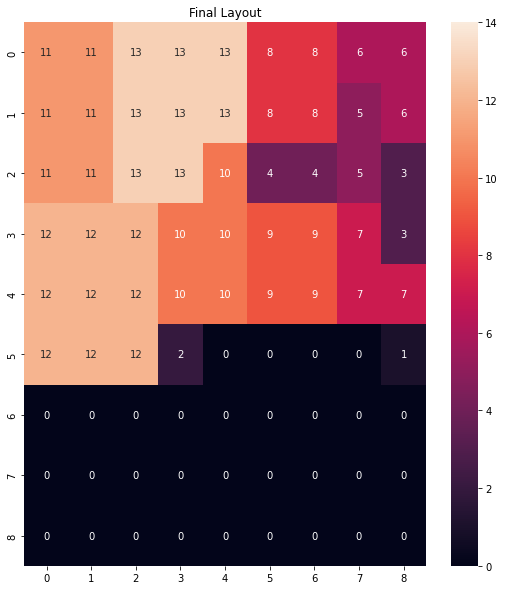

In [16]:
# t3 = time.time()
print(sampleset)
sample = sampleset.first.sample
# print(sample)

layout_val = sample.values()
layout_val = np.array(list(layout_val))
# print(layout_val)

for f in facilities:
    if (layout_val==f).sum() != facility_size[f]:
        print(f"incorrect size of facility {f}, correct size = {facility_size[f]}, calculated size = {(layout_val==f).sum()}")
    else:
        print(f"correct size of facility {f} calculated")



layout = layout_val.reshape(factory_rows,factory_collumns)
fig, ax = plt.subplots(figsize=(9, 10))
sns.heatmap(layout,annot = layout, vmin = 0, vmax = len(facilities)).set(title = "Final Layout")